# CycleGAN

## Set up the input pipeline

In [61]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-62ldwwc1
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-62ldwwc1


In [62]:
import tensorflow as tf

In [63]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## Input Pipeline

사과->오렌지 이미지로 변환하도록 모델 훈련

jittering과 mirroring 사용

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* random jittering: `286 x 286` 사이즈로 임의 조정 후  `256 x 256`로 무작위로 crop
* random mirroring: 이미지가 무작위로 좌우반전

In [64]:
dataset, metadata = tfds.load('cycle_gan/apple2orange',
                              with_info=True, as_supervised=True)

train_apple, train_orange = dataset['trainA'], dataset['trainB']
test_apple, test_orange = dataset['testA'], dataset['testB']

In [65]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [66]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [67]:
# [-1, 1]로 이미지 정규화
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [68]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [69]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [70]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [71]:
train_apple = train_apple.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_orange = train_orange.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_apple = test_apple.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_orange = test_orange.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [72]:
sample_apple = next(iter(train_apple))
sample_orange = next(iter(train_orange))

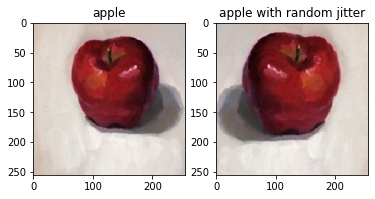

In [73]:
#jittering 결과
plt.subplot(121)
plt.title('apple')
plt.imshow(sample_apple[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('apple with random jitter')
plt.imshow(random_jitter(sample_apple[0]) * 0.5 + 0.5)

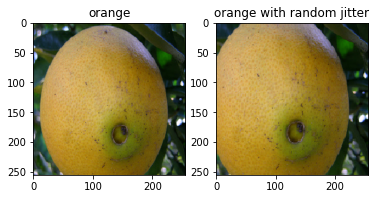

In [74]:
#mirroring 결과
plt.subplot(121)
plt.title('orange')
plt.imshow(sample_orange[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('orange with random jitter')
plt.imshow(random_jitter(sample_orange[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

pix2pix와 유사한 모델 사용

* Cyclegan은 배치 정규화 대신 인스턴스 정규화 사용
* 원래 `resnet` 기반 generator 사용하지만 현재는 `unet` generator 사용

2개의 생성기(G 및 F)와 2개의 판별자(X 및 Y)를 훈련

* Generator `G` 는 image `X` -> image `Y` 변환 방법 학습
* Generator `F` 는 image `Y` -> image `X` 변환 방법 학습
* Discriminator `D_X` 는 image `X` 와 생성된 image `X` (`F(Y)`) 구별하는 방법 학습
* Discriminator `D_Y` 는 image `Y` 와 생성된 image `Y` (`G(X)`) 구별하는 방법 학습



In [75]:
#인스턴스 정규화
OUTPUT_CHANNELS = 3

#unet generator
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

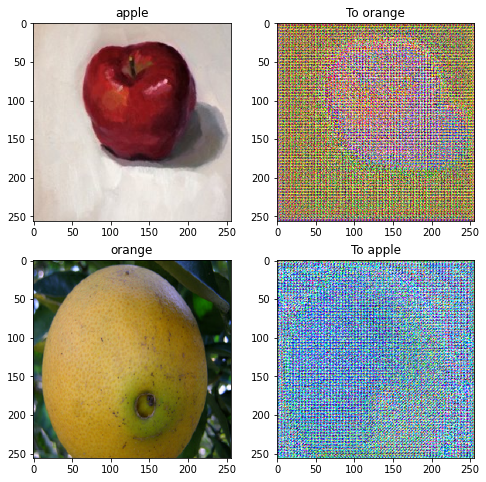

In [76]:
to_orange = generator_g(sample_apple)
to_apple = generator_f(sample_orange)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_apple, to_orange, sample_orange, to_apple]
title = ['apple', 'To orange', 'orange', 'To apple']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

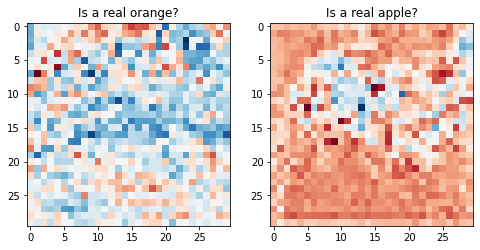

In [77]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real orange?')
plt.imshow(discriminator_y(sample_orange)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real apple?')
plt.imshow(discriminator_x(sample_apple)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In [78]:
LAMBDA = 10

In [79]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [80]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [81]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

주기 일관성 손실

* Image $X$ 는 generator $G$ 통해 전달되어 $\hat{Y}$의 생성된 이미지 생성.
* $\hat{Y}$ 의 생성된 이미지는 generator $F$ 통해 전달되어 $\hat{X}$의 순환 이미지 생성.
* $X$ and $\hat{X}$ 사이에서 평균 절대 오차 계산.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$



In [82]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

generator $G$는 image $X$ -> $Y$ 변환 역할
identity loss는 image $Y$ 를 generator $G$에 공급하면 실제 이미지 $Y$ or image $Y$에 가까운 이미지 생성 지시.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [83]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [84]:
#모든 generator와 discriminator의 optimizer 초기화
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [85]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 체크포인트가 존재하면 최신 체크포인트 저장
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

200 epoch가 적절하지만 일닩 20만 train

In [86]:
EPOCHS = 20

In [87]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

training loop

* 예측을 얻기
* 손실 계산
* 역전파 사용해 gradient 계산
* gradient를 optimizer에 적용

In [88]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

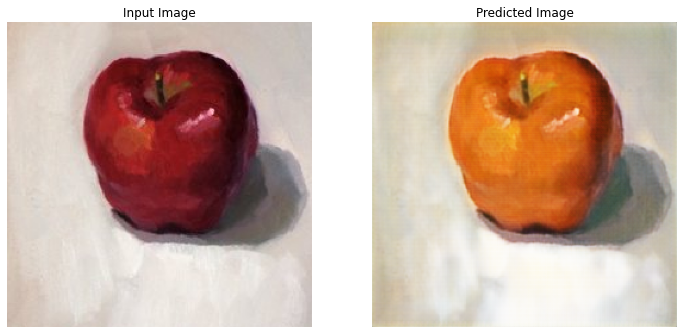

Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Time taken for epoch 20 is 830.2011604309082 sec



In [90]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_apple, train_orange)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_apple)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Generate using test dataset

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

## Next steps

This tutorial has shown how to implement CycleGAN starting from the generator and discriminator implemented in the [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial. As a next step, you could try using a different dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan). 

You could also train for a larger number of epochs to improve the results, or you could implement the modified ResNet generator used in the [paper](https://arxiv.org/abs/1703.10593) instead of the U-Net generator used here.